# Mehrstufige Extraktion von Metadateninformationen aus sächsischen OER Inhalten

Sebastian Zug, André Dietrich 
TU Bergakademie Freiberg, Institut für Informatik

In [57]:
import pandas as pd
from pathlib import Path
import difflib

## 1. Schritt: Bewertung der Metadaten von OER Inhalten aus dem LMS OPAL

In [58]:
data_folder =  "/mnt/9cd5c6a1-07f3-4580-be34-8d8dd9d6fe6d/Connected_Lecturers/Opal/raw/"
data_file_attribs = "OPAL_files_attrib.p"
data_file_meta = "OPAL_files_meta.p"

In [59]:
df_files = pd.read_pickle(Path(data_folder) / data_file_attribs)

In [60]:
def generateEmptinessStatistics(df):
    df_empty = df.apply(lambda x: x == '').sum(axis=0).rename("count").to_frame()
    df_empty['empty_in_percent'] = df_empty / len(df)
    return df_empty 

In [61]:
generateEmptinessStatistics(df_files)

,count,empty_in_percent
opal:filename,0,0.000000
opal:oer_permalink,0,0.000000
opal:license,0,0.000000
opal:creator,13741,0.980450
opal:title,13699,0.977453
opal:comment,13841,0.987585
opal:language,13982,0.997645
opal:publicationMonth,13830,0.986800
opal:publicationYear,13830,0.986800
pipe:ID,0,0.000000


Ok, wer sind die metainformationsspezifischen Vorbilder?

In [62]:
df_files[df_files["opal:creator"]!=""]['opal:creator'].value_counts().head(10)

opal:creator
Frank Babick                             91
Dominik Kern                             20
Monique Meier                            10
Daniela Dobeleit                          7
Benno Wessely; Frank Babick               5
Valerie Uhlig                             5
Guido Philipp                             4
Nielsen Book Data                         4
Hartmut Simmert                           3
Jessica Kluge und Melanie Trützschler     3
Name: count, dtype: int64

## Schritt 2: Traditionelle Aggregation der Metadaten

Welche Dateitypen sind denn  in den OPAL OER Daten überhaupt vertreten?

In [63]:
df_files["pipe:file_type"].value_counts().head(10)

pipe:file_type
pdf     6962
jpg     1237
mkv      869
mp4      602
png      563
zip      466
docx     441
html     430
pptx     224
xlsx     208
Name: count, dtype: int64

Im Rahmen der ersten Untersuchungsreihe fokussieren wir uns auf {`pdf`, `docx`, `pptx`, `xlsx`}. Ausgangspunkt war eine Stichprobenprüfung der Mediendateien, die keinerlei Metadaten enthielten.

In [64]:
relevant_file_type = ['pdf', 'docx', 'pptx', 'xlsx']
print(df_files[df_files["pipe:file_type"].isin(relevant_file_type)]["pipe:file_type"].shape[0] )
print(df_files[df_files["pipe:file_type"].isin(relevant_file_type)]["pipe:file_type"].shape[0] / df_files.shape[0])

7835
0.5590438815554762


Offenbar decken wir mit dieser Auswahl etwa 55 Prozent der in OPAL enthaltenen Dokumente ab. Für diese Datentypen existieren unterschiedliche Metadateninformationen, die in die Dateien eingebettet sind. 

![](https://redmondmag.com/articles/2019/02/25/~/media/ECG/redmondmag/Images/2019/02/0225red_metadata1.ashx)

Ein Skript der CL Pipeline hat diese, sofern vorhanden, für uns ausgelesen ...

In [65]:
df_meta = pd.read_pickle(Path(data_folder) / data_file_meta)
generateEmptinessStatistics(df_meta)

,count,empty_in_percent
pipe:ID,0,0.000000
pipe:file_type,0,0.000000
file:author,2852,0.364008
file:keywords,6899,0.880536
file:subject,6561,0.837396
file:title,3502,0.446969
file:created,0,0.000000
file:modified,0,0.000000
file:language,654,0.083472


Für 60 Prozent der Autoren können wir zumindest einen Vorschlage zum Namen machen? Das klingt schon mal vielversprechend. Lassen Sie uns die Metadaten der verschiedenen Quellen vergleichen, um die Qualitäten zu prüfen.

In [66]:
# merge df_files and df_meta on "opal:file_id"
df_merge = pd.merge(df_meta, df_files.drop(['pipe:file_type'], axis=1), on="pipe:ID", how="left")

Schauen wir uns zunächst positiv Beispiel an, die aus beiden Quellen enthielten.

In [67]:
df_merge[(df_merge["opal:creator"]!="") &  (df_merge["file:author"]!="")][["opal:creator", "file:author"]].head(15)

,opal:creator,file:author
300,ESRI,ESRI
308,Prof. Dr. Nadine Bergner,Prof. Dr. Nadine Bergner
360,Jost-Hinrich Eschenburg,Jost-Hinrich Eschenburg
379,"Roeder, Klimova, Kuhn",Institute of Medical Informatics and Biometry ...
400,Frank Babick,Frank Babick u.a.
423,Frank Babick,Frank Babick
424,Frank Babick,Frank Babick
443,Frank Babick,Frank Babick
486,Sophia Peukert; Frank Irmler,ms733714
527,Oliver Löwe,Löwe Oliver


Und nun umgekehrt, helfen uns die aus den Dateien extrahierten Metadaten bei der Identifikation der Autoren? Das Bild ist durchwachsen ...

In [68]:
df_merge[(df_merge["opal:creator"]=="") &  (df_merge["file:author"]!="")][["opal:creator", "file:author"]].head(15)

,opal:creator,file:author
5,,Ralf Laue
6,,"Walter, Susanne (FIN A 2.3)"
10,,home
11,,home
12,,home
21,,Anja
22,,Anna
23,,P. Menzel;Hamza
24,,lschlenker
25,,"Rana M. Tamim, Robert M. Bernard, Eugene Borok..."


Wir brauchen einen weiteren Mechanismus der uns bei der Extraktion unterstützt! 

### Schritt 3: KI basierte Metadatenaggregation

Die CL Pipeline wurde um ein weiteres Modul erweitert, dass aktuell ein llama3 LLM verwendet, um die Titel, Autoren und Keyworte zu extrahieren.

In [69]:
data_file_aimeta = "OPAL_ai_meta.p"
df_aimeta = pd.read_pickle(Path(data_folder) / data_file_aimeta)

In [70]:
df_aimeta.shape[0] / df_files[df_files["pipe:file_type"].isin(relevant_file_type)]["pipe:file_type"].shape[0] 

0.9363114231014678

Für etwa 90 Prozent der Office-Dateien und pdfs konnten entsprechende Informationen erschlossen werden. Die Frage ist, wie schlüssig diese Resultate sind. Fusionieren wir also alle Datensätze miteinander, um das zu untersuchen.

In [71]:
df_merge_all = pd.merge(df_aimeta, df_merge.drop(['pipe:file_type'], axis=1), on="pipe:ID", how="left")
df_merge_all.iloc[0]

pipe:ID                                                       8I6sM5zapD60
pipe:file_type                                                         pdf
ai:author                                    Stephan Gerhold, Marcel Beyer
ai:title                                         "Übung 3 Photogrammetrie"
ai:keywords              Fensterabstand, Photogrammetrie, Passpunkte, E...
file:author                                                               
file:keywords                                                             
file:subject                                                              
file:title                                                                
file:created                                     2019-01-11 17:12:31+00:00
file:modified                                    2019-01-11 17:12:31+00:00
file:language                                                          NaN
opal:filename                                                    beleg.pdf
opal:oer_permalink       

Schauen wir uns also zunächst die Datensätze an, die sowohl Metadaten aus OPAL mitbrachten, für die aber auch Daten generiert werden konnten.

In [72]:
df_merge_all[ (df_merge_all["opal:creator"]!="") &
             ((df_merge_all["file:author"]!="") | (df_merge_all["ai:author"]!=""))][["opal:creator", "file:author", "ai:author", "pipe:file_type"]].tail(20)

,opal:creator,file:author,ai:author,pipe:file_type
6705,"Michael Stintz, Frank Babick","Michael Stintz, Frank Babick","F. Löffler, J. Raasch",pdf
6708,"Michael Stintz, Frank Babick",Frank Babick,DIN,pdf
6715,Dominik Kern,Dominik Kern,Dominik Kern,pdf
6747,Frank Babick,Frank Babick,Frank Babick,pdf
6748,Frank Babick,Frank Babick,Frank Babick,pdf
6793,Dominik Kern,Dominik Kern,Dominik Kern,pdf
6803,Frank Babick,Frank Babick,Frank Babick,pdf
6805,Dominik Kern,Dominik Kern,Dominik Kern,pdf
6868,Frank Babick,Frank Babick,Frank Babick,pdf
6869,Frank Babick,Frank Babick,Frank Babick,pdf


... und umgekehrt? Wo können `ai` und `file` zum Beispiel Lücken bei den Autoren füllen? 

In [73]:
df_merge_all = df_merge_all[~df_merge_all['ai:author'].str.contains("Ich kann")]

In [74]:
df_merge_all[ (df_merge_all["opal:creator"]=="") &
             ((df_merge_all["file:author"]!="") | (df_merge_all["ai:author"]!=""))][["file:author", "ai:author", "pipe:file_type"]].head(20)

,file:author,ai:author,pipe:file_type
0,,"Stephan Gerhold, Marcel Beyer",pdf
3,,Norbert Engemaier,pdf
5,Ralf Laue,,pdf
6,"Walter, Susanne (FIN A 2.3)",,docx
7,,TU Dresden,pdf
8,,Medienzentrum,pdf
9,home,,pdf
10,home,,pdf
11,home,,pdf
12,,Medienzentrum,pdf


Können wir ein Vertrauensmaß definieren, dass uns hilft, die Qualität der Metadaten zu bewerten?

In [75]:
def check_substrings(row):
    if row["file:author"]!="" and row["ai:author"]!="" and row["file:author"]!=None and row["ai:author"]!=None:
        input_a = row["file:author"]
        input_b = row["ai:author"]
        s = difflib.SequenceMatcher(None, input_a, input_b)
        return s.find_longest_match(0, len(input_a), 0, len(input_b)).size
    else:
        return None
    
df_merge_all['common_substring_count'] = df_merge_all.apply(check_substrings, axis=1)

<Axes: ylabel='Frequency'>

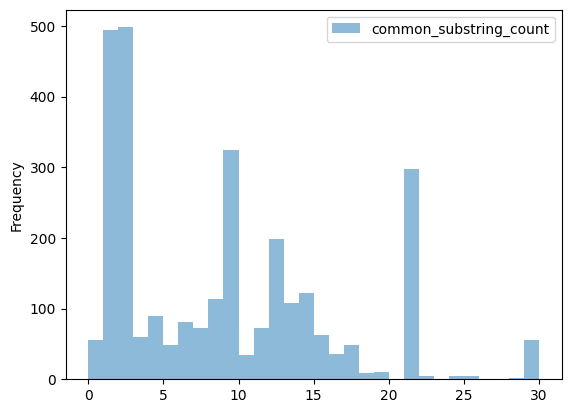

In [76]:
df_merge_all.plot.hist(y='common_substring_count', bins=range(0, 31, 1), alpha=0.5)

In [77]:
df_merge_all[(df_merge_all.common_substring_count > 3)][["file:author", "ai:author", "pipe:file_type", "common_substring_count"]]

,file:author,ai:author,pipe:file_type,common_substring_count
16,Anna,Anna Hagedorn,docx,4.0
20,"Prof.Dr. Florian Sahling, name@subdomain.domain",Prof. Dr. Florian Sahling,pdf,19.0
26,Yvonne Seidel,Yvonne Seidel,pdf,13.0
30,"Beurskens, Michael",Prof. Dr. Beurskens,pdf,9.0
31,Jens Krzywinski,Jun.-Prof. Dr.-Ing. Jens Krzywinski,pdf,15.0
...,...,...,...,...
7279,Braun,Dr.-Ing. Iris Braun,pptx,5.0
7288,Johannes Götze,Maurice Domnick und Johannes Götze,pptx,14.0
7306,Helene B,Helene Baumgarten,pptx,8.0
7331,Niclas,Niclas Pitterling,pptx,6.0
